### Imports

In [1]:
import copy
import pymysql
import numpy as np
import pandas as pd
import math

### MySQL Settings

In [2]:
conn = pymysql.connect(host='localhost', port=3306, user='root', password='root', db='homedb')

### Compute semantic bugs co-occurrence 

In [3]:
error_labels = 'E001 E002 E003 E004 E005 E006 E007 E008 E009 E010 E011 E012 E013 E014 E015 E016 E017 E018 E019 E020 E021 E022 E023 E024 E025'.split(' ')

In [4]:
get_bugs = 'SELECT * FROM bugs'
error_codes = np.empty((0, 25), int)

bugs = pd.read_sql(get_bugs, conn)

def get_error_code(error):
    if 'E00' in error:
        return int(error.split('E00')[1])
    return int(error.split('E0')[1])

def count_error_codes(row):
    global error_codes
    error_codes = np.append(error_codes, np.array([np.zeros(25, dtype=int)]), axis=0)
    row_index = len(error_codes) - 1
    errors = row.errors.replace('[', '').replace(']', '')
    errors = errors.split(',')
    for error in errors:
        error = error.replace(',', '').strip()
        col_index = get_error_code(error) - 1
        error_codes[row_index, col_index] = 1

bugs['errors'] = bugs.apply(count_error_codes, axis=1)

In [5]:
len(error_codes)

28377

In [6]:
get_bugs = 'SELECT * FROM evo_sql_bugs'

bugs = pd.read_sql(get_bugs, conn)

def get_error_code(error):
    if 'E00' in error:
        return int(error.split('E00')[1])
    return int(error.split('E0')[1])

def count_error_codes(row):
    global error_codes
    error_codes = np.append(error_codes, np.array([np.zeros(25, dtype=int)]), axis=0)
    row_index = len(error_codes) - 1
    errors = row.errors.replace('[', '').replace(']', '')
    errors = errors.split(',')
    for error in errors:
        error = error.replace(',', '').strip()
        col_index = get_error_code(error) - 1
        error_codes[row_index, col_index] = 1

bugs['errors'] = bugs.apply(count_error_codes, axis=1)

In [7]:
len(error_codes)

36818

In [8]:
get_queries = 'SELECT * FROM queries WHERE is_valid="1"'
queries = pd.read_sql(get_queries, conn)
get_queries = 'SELECT * FROM evo_sql_queries WHERE is_valid="1"'
queries_evo_sql = pd.read_sql(get_queries, conn)
print(f'queries: {len(queries)}')
print(f'queries evo: {len(queries_evo_sql)}')
num_queries = len(queries) + len(queries_evo_sql)
print(f'total queries: {num_queries}')

queries: 172841
queries evo: 19153
total queries: 191994


In [9]:
# compute co-occurrence matrix
cooccurrence_matrix = np.dot(error_codes.transpose(), error_codes)
# fill diagonal with zeros
np.fill_diagonal(cooccurrence_matrix, 0)
print('\ncooccurrence_matrix:\n{0}'.format(cooccurrence_matrix))

# compute co-occurrence matrix in percentage
cooccurrence_matrix_percentage = np.empty((0, 25), float)

row_index = 0
for row in cooccurrence_matrix:
    col_index = 0
    cooccurrence_matrix_percentage = np.append(cooccurrence_matrix_percentage, np.array([np.zeros(25, dtype=float)]), axis=0)
    for value in row:
        tmp_sum = cooccurrence_matrix[row_index].sum() + cooccurrence_matrix[col_index].sum()
        cooccurrence_matrix_percentage[row_index, col_index] = value / tmp_sum
        # s_i = cooccurrence_matrix[row_index, row_index]
        # s_j = cooccurrence_matrix[col_index, col_index]
        # if s_i * s_j != 0:
        #    cooccurrence_matrix_percentage[row_index, col_index] = cooccurrence_matrix[row_index, col_index] / math.sqrt(s_i * s_j)
        col_index += 1
    row_index += 1
print('\ncooccurrence_matrix_percentage:\n{0}'.format(cooccurrence_matrix_percentage))

# np.fill_diagonal(cooccurrence_matrix_percentage, 1.0)


cooccurrence_matrix:
[[  0   4   0   0   0   0   0   0   0   1   0   2   2   0   0   0   0   0
    0   0   1   0   0   0   0]
 [  4   0  36   7   0   2   0  12   3 124   2 152  68  37 136  52 256  23
  694   2  20   3  22  63   9]
 [  0  36   0   0   0   0   0   4   0   3   0  10  11   1   1   0   3   0
   40   0   2   0   2   0   0]
 [  0   7   0   0   0   0   0   2   0   1   0   5   8   2   0   1   2   0
   14   0   1   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   8   1   1   0   0   0   1
   10   0   2   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    2   0   0   0   0   0   0]
 [  0  12   4   2   0   0   0   0   0  19   0  16   3   3   2   0   4   1
   30   1   1   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   5   2   1   1   0   1   0
    8   3   0   1   0   0   0]
 [  1 124   3   1   0   0   0  19

C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


### Code for generating heatmap for co-occurrence matrix (inspired from stackoverflow)

labels:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


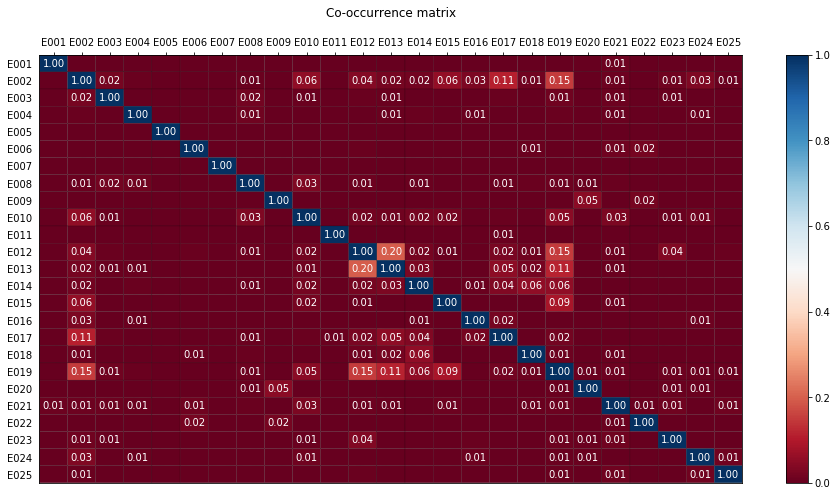

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        if (fmt % value) != '0.00':
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))


# Using previously computed error_codes and error_labels data
label_headers = error_labels
label_data = error_codes
print('labels:\n{0}'.format(label_data))
np.fill_diagonal(cooccurrence_matrix_percentage, 1)

# Plotting
x_axis_size = cooccurrence_matrix_percentage.shape[0]
y_axis_size = cooccurrence_matrix_percentage.shape[1]
title = "Co-occurrence matrix\n"
xlabel= ''#"Labels"
ylabel= ''#"Labels"
xticklabels = label_headers
yticklabels = label_headers
heatmap(cooccurrence_matrix_percentage, title, xlabel, ylabel, xticklabels, yticklabels)
# plt.savefig('matrix_combined.pdf', dpi=300, format='pdf', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
plt.show()